In [98]:
import pandas as pd
import mysql.connector
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
from datetime import datetime
import os
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler


In [2]:
data= pd.read_csv('fial_tomato.csv')
print(data.head())


         market date_started week_end_date  price_per_quintal  year  month
0  Achalda APMC   2025-11-01    2025-11-08            1866.55  2025     11
1  Achnera APMC   2025-11-01    2025-11-08            1930.77  2025     11
2     Agra APMC   2025-11-01    2025-11-08            1844.26  2025     11
3  Ahirora APMC   2025-11-01    2025-11-08                NaN  2025     11
4    Ajuha APMC   2025-11-01    2025-11-08            2042.54  2025     11


In [3]:
connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="1234",
    database="tomato_db"
)


In [4]:
df = pd.read_sql(
    """
    SELECT
    market_name,
    week_start_date,
    week_end_date,
    price_per_quintal,
    year,
    month,
    week_number
    FROM tomato_prices
    ORDER BY market_name, week_start_date
    """,connection)   

/var/folders/f_/_06tnpvn1l7gnknsb04y2djc0000gn/T/ipykernel_45210/1252397887.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [5]:
df

,market_name,week_start_date,week_end_date,price_per_quintal,year,month,week_number
0,Achalda APMC,2022-11-01,2022-11-08,2181.43,2022,11,44
1,Achalda APMC,2022-11-09,2022-11-15,1716.09,2022,11,45
2,Achalda APMC,2022-11-16,2022-11-23,1503.45,2022,11,46
3,Achalda APMC,2022-11-24,2022-11-30,1587.83,2022,11,47
4,Achalda APMC,2022-12-01,2022-12-08,1474.12,2022,12,48
...,...,...,...,...,...,...,...
28946,Yusufpur APMC,2025-07-16,2025-07-23,NaN,2025,7,29
28947,Yusufpur APMC,2025-07-24,2025-07-31,NaN,2025,7,30
28948,Yusufpur APMC,2025-10-09,2025-10-15,1550.00,2025,10,41
28949,Yusufpur APMC,2025-10-16,2025-10-23,NaN,2025,10,42


In [6]:
df.head()

,market_name,week_start_date,week_end_date,price_per_quintal,year,month,week_number
0,Achalda APMC,2022-11-01,2022-11-08,2181.43,2022,11,44
1,Achalda APMC,2022-11-09,2022-11-15,1716.09,2022,11,45
2,Achalda APMC,2022-11-16,2022-11-23,1503.45,2022,11,46
3,Achalda APMC,2022-11-24,2022-11-30,1587.83,2022,11,47
4,Achalda APMC,2022-12-01,2022-12-08,1474.12,2022,12,48


In [7]:
print(f"Loaded {len(df)} records")

Loaded 28951 records


In [8]:
df.isnull().sum()

market_name             0
week_start_date         0
week_end_date           0
price_per_quintal    2969
year                    0
month                   0
week_number             0
dtype: int64

In [9]:
df['price_per_quintal'] = (
    df.groupby('market_name')['price_per_quintal']
      .transform(lambda s: s.ffill(limit=2))
)

In [10]:
df

,market_name,week_start_date,week_end_date,price_per_quintal,year,month,week_number
0,Achalda APMC,2022-11-01,2022-11-08,2181.43,2022,11,44
1,Achalda APMC,2022-11-09,2022-11-15,1716.09,2022,11,45
2,Achalda APMC,2022-11-16,2022-11-23,1503.45,2022,11,46
3,Achalda APMC,2022-11-24,2022-11-30,1587.83,2022,11,47
4,Achalda APMC,2022-12-01,2022-12-08,1474.12,2022,12,48
...,...,...,...,...,...,...,...
28946,Yusufpur APMC,2025-07-16,2025-07-23,650.00,2025,7,29
28947,Yusufpur APMC,2025-07-24,2025-07-31,650.00,2025,7,30
28948,Yusufpur APMC,2025-10-09,2025-10-15,1550.00,2025,10,41
28949,Yusufpur APMC,2025-10-16,2025-10-23,1550.00,2025,10,42


In [11]:
df.describe()

,price_per_quintal,year,month,week_number
count,27349.000000,28951.000000,28951.000000,28951.000000
mean,1998.303880,2023.853580,6.557528,26.650202
std,1419.753751,0.900438,3.463513,15.031020
min,200.000000,2022.000000,1.000000,1.000000
25%,1000.000000,2023.000000,4.000000,14.000000
50%,1615.000000,2024.000000,7.000000,27.000000
75%,2480.370000,2025.000000,10.000000,40.000000
max,9500.000000,2025.000000,12.000000,52.000000


In [12]:
df.isnull().any()


market_name          False
week_start_date      False
week_end_date        False
price_per_quintal     True
year                 False
month                False
week_number          False
dtype: bool

In [13]:
df.isnull().sum()

market_name             0
week_start_date         0
week_end_date           0
price_per_quintal    1602
year                    0
month                   0
week_number             0
dtype: int64

In [14]:
df.shape

(28951, 7)

In [15]:
df['price_per_quintal'] = df.groupby('market_name')['price_per_quintal'].apply(lambda x: x.interpolate(method='linear')).reset_index(level=0, drop=True)


In [16]:
df.shape

(28951, 7)

In [17]:
df.dropna(subset=['price_per_quintal'], inplace=True)

In [18]:
print(f"After cleaning: {len(df)} records")

After cleaning: 28720 records


In [19]:
df.isnull().any()


market_name          False
week_start_date      False
week_end_date        False
price_per_quintal    False
year                 False
month                False
week_number          False
dtype: bool

In [20]:
def remore_outliers(grp):
    mean = df['price_per_quintal'].mean()
    std = df['price_per_quintal'].std()
    mask = (grp['price_per_quintal']>=mean-3 * std) & (grp['price_per_quintal']<=mean+3 * std)
    return grp[mask]


In [21]:
df= df.groupby('market_name').apply(remore_outliers).reset_index(drop=True)

/var/folders/f_/_06tnpvn1l7gnknsb04y2djc0000gn/T/ipykernel_45210/1830244468.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df= df.groupby('market_name').apply(remore_outliers).reset_index(drop=True)


In [22]:
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df['week_end_date'] = pd.to_datetime(df['week_end_date'])
df['day_of_week'] = df['week_start_date'].dt.dayofweek
df['quarter'] = df['week_start_date'].dt.quarter
df['is_month_start'] = df['week_start_date'].dt.is_month_start
df['is_month_end'] = df['week_start_date'].dt.is_month_end


In [23]:
df

,market_name,week_start_date,week_end_date,price_per_quintal,year,month,week_number,day_of_week,quarter,is_month_start,is_month_end
0,Achalda APMC,2022-11-01,2022-11-08,2181.43,2022,11,44,1,4,True,False
1,Achalda APMC,2022-11-09,2022-11-15,1716.09,2022,11,45,2,4,False,False
2,Achalda APMC,2022-11-16,2022-11-23,1503.45,2022,11,46,2,4,False,False
3,Achalda APMC,2022-11-24,2022-11-30,1587.83,2022,11,47,3,4,False,False
4,Achalda APMC,2022-12-01,2022-12-08,1474.12,2022,12,48,3,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...
27938,Yusufpur APMC,2025-07-16,2025-07-23,650.00,2025,7,29,2,3,False,False
27939,Yusufpur APMC,2025-07-24,2025-07-31,650.00,2025,7,30,3,3,False,False
27940,Yusufpur APMC,2025-10-09,2025-10-15,1550.00,2025,10,41,3,4,False,False
27941,Yusufpur APMC,2025-10-16,2025-10-23,1550.00,2025,10,42,3,4,False,False


In [24]:
def create_lag_features(df, lags=[1, 2, 4, 8, 12]):
    """
    Create lagged price features
    lags: List of weeks to look back
    """
    df = df.sort_values(['market_name', 'week_start_date'])
    for lag in lags:
        df[f'price_lag_{lag}'] = df.groupby('market_name')['price_per_quintal'].shift(lag)
    return df
df = create_lag_features(df)


In [25]:
def create_rolling_features(df,windows= [4,8,12]):
    """
    create rolling mean, std, min, max
    windows: Rolling window sizes in weeks
    """
    df =  df.sort_values(['market_name','week_start_date'])
    for window in windows:
        df[f'price_mean_{window}'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'price_std_{window}'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(window=window, min_periods=1).std())
        df[f'price_min_{window}'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(window=window, min_periods=1).min())
        df[f'price_max_{window}'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(window=window, min_periods=1).max())
    return df 
df = create_rolling_features(df)


In [26]:
def create_growth_features(df):
    """
    Calculate price change rates
    """
    df = df.sort_values(['market_name','week_start_date'])
    df['price_growth_1w'] = df.groupby('market_name')['price_per_quintal'].pct_change(1)
    df['price_growth_4w'] = df.groupby('market_name')['price_per_quintal'].pct_change(4)
    df['price_growth_12w'] = df.groupby('market_name')['price_per_quintal'].pct_change(12)
    df['price_ma_4'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(4, min_periods=1).mean())
    df['price_ma_8'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(8, min_periods=1).mean())
    df['price_ma_12'] = df.groupby('market_name')['price_per_quintal'].transform(lambda x: x.rolling(12, min_periods=1).mean())
    df['price_momentum'] = df['price_per_quintal'] -df['price_ma_4']
    df['price_relative_strength'] = df['price_per_quintal'] / df['price_ma_12']
    return df
df = create_growth_features(df)


In [27]:
def create_seasonal_features(df):
    """
    Add seasonal indicators
    """
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['week_sin'] = np.sin(2 * np.pi * df['week_number'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week_number'] / 52)
    def get_season(month):
        if month in [11, 12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5, 6]:
            return 'summer'
        else:
            return 'monsoon'
    df['season'] = df['month'].apply(get_season)
    df = pd.get_dummies(df, columns=['season'], prefix='season')
    return df


In [28]:
def create_market_features(df):
    """
    Add market-specific features
    """
    market_avg = df.groupby('market_name')['price_per_quintal'].mean().to_dict()
    df['market_avg_price'] = df['market_name'].map(market_avg)
    df['price_vs_market_avg'] = df['price_per_quintal'] - df['market_avg_price']
    market_std = df.groupby('market_name')['price_per_quintal'].std().to_dict()
    df['market_volatility'] = df['market_name'].map(market_std)
    le = LabelEncoder()
    df['market_encoded'] = le.fit_transform(df['market_name'])
    return df

In [29]:
df = create_seasonal_features(df)
df = create_market_features(df)

In [30]:
FEATURE_COLUMNS = [
    'price_lag_1',
    'price_lag_2',
    'price_lag_4',
    'price_lag_8',
    'price_lag_12',
    'price_ma_4',
    'price_std_4',
    'price_min_4',
    'price_max_4',
    'price_ma_8',
    'price_std_8',
    'price_min_8',
    'price_max_8',
    'price_ma_12',
    'price_std_12',
    'price_min_12',
    'price_max_12',
    'price_growth_1w',
    'price_momentum',
    'price_growth_4w',
    'price_growth_12w',
    'price_relative_strength',
    'month',
    'week_number',
    'month_sin',
    'month_cos',
    'season_winter',
    'season_summer',
    'season_monsoon',
    'day_of_week',
    'is_month_start',
    'is_month_end',
    'quarter',
    'week_sin',
    'week_cos',
    'market_encoded',
    'market_avg_price',
    'price_vs_market_avg',
    'market_volatility',
    'year'
]
TARGET_COLUMN = 'price_per_quintal'


In [74]:
len(FEATURE_COLUMNS)

40

In [31]:
train = df[df['week_start_date'] < '2025-09-01']
test = df[df['week_start_date'] >= '2025-09-01']

In [39]:
df.columns

Index(['market_name', 'week_start_date', 'week_end_date', 'price_per_quintal',
       'year', 'month', 'week_number', 'day_of_week', 'quarter',
       'is_month_start', 'is_month_end', 'price_lag_1', 'price_lag_2',
       'price_lag_4', 'price_lag_8', 'price_lag_12', 'price_mean_4',
       'price_std_4', 'price_min_4', 'price_max_4', 'price_mean_8',
       'price_std_8', 'price_min_8', 'price_max_8', 'price_mean_12',
       'price_std_12', 'price_min_12', 'price_max_12', 'price_growth_1w',
       'price_growth_4w', 'price_growth_12w', 'price_ma_4', 'price_ma_8',
       'price_ma_12', 'price_momentum', 'price_relative_strength', 'month_sin',
       'month_cos', 'week_sin', 'week_cos', 'season_monsoon', 'season_summer',
       'season_winter', 'market_avg_price', 'price_vs_market_avg',
       'market_volatility', 'market_encoded'],
      dtype='object')

In [40]:
df.shape

(27943, 47)

In [33]:
train

,market_name,week_start_date,week_end_date,price_per_quintal,year,month,week_number,day_of_week,quarter,is_month_start,...,month_cos,week_sin,week_cos,season_monsoon,season_summer,season_winter,market_avg_price,price_vs_market_avg,market_volatility,market_encoded
0,Achalda APMC,2022-11-01,2022-11-08,2181.43,2022,11,44,1,4,True,...,0.866025,-8.229839e-01,0.568065,False,False,True,1861.222199,320.207801,1112.370854,0
1,Achalda APMC,2022-11-09,2022-11-15,1716.09,2022,11,45,2,4,False,...,0.866025,-7.485107e-01,0.663123,False,False,True,1861.222199,-145.132199,1112.370854,0
2,Achalda APMC,2022-11-16,2022-11-23,1503.45,2022,11,46,2,4,False,...,0.866025,-6.631227e-01,0.748511,False,False,True,1861.222199,-357.772199,1112.370854,0
3,Achalda APMC,2022-11-24,2022-11-30,1587.83,2022,11,47,3,4,False,...,0.866025,-5.680647e-01,0.822984,False,False,True,1861.222199,-273.392199,1112.370854,0
4,Achalda APMC,2022-12-01,2022-12-08,1474.12,2022,12,48,3,4,True,...,1.000000,-4.647232e-01,0.885456,False,False,True,1861.222199,-387.102199,1112.370854,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27935,Yusufpur APMC,2024-05-24,2024-05-31,790.00,2024,5,21,4,2,False,...,-0.866025,5.680647e-01,-0.822984,False,True,False,845.671458,-55.671458,268.454883,218
27936,Yusufpur APMC,2025-06-16,2025-06-23,720.00,2025,6,25,0,2,False,...,-1.000000,1.205367e-01,-0.992709,False,True,False,845.671458,-125.671458,268.454883,218
27937,Yusufpur APMC,2025-06-24,2025-06-30,650.00,2025,6,26,1,2,False,...,-1.000000,-3.216245e-16,-1.000000,False,True,False,845.671458,-195.671458,268.454883,218
27938,Yusufpur APMC,2025-07-16,2025-07-23,650.00,2025,7,29,2,3,False,...,-0.866025,-3.546049e-01,-0.935016,True,False,False,845.671458,-195.671458,268.454883,218


In [34]:
X_train = train[FEATURE_COLUMNS].fillna(0)
y_train = train[TARGET_COLUMN]
X_test = test[FEATURE_COLUMNS].fillna(0)
y_test = test[TARGET_COLUMN]

In [35]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (25935, 40)
y_train shape: (25935,)
X_test shape: (2008, 40)
y_test shape: (2008,)


In [ ]:
xgb_params = {
    'max_depth': 6,              
    'min_child_weight': 3,       
    'gamma': 0.1,                
    'n_estimators': 200,         
    'learning_rate': 0.05,       
    'subsample': 0.8,            
    'colsample_bytree': 0.8,     
    'reg_alpha': 0.1,            
    'reg_lambda': 1.0,     
    'objective': 'reg:squarederror',  
    'random_state': 42, 
    'n_jobs': -1,                
    'verbosity': 1
}


In [46]:
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

In [52]:
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"\nTraining Fold {fold + 1}/5...")
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds=20)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    cv_scores.append({
        'fold': fold + 1,
        'mae': mae,
        'mape': mape,
        'rmse': rmse,
        'r2': r2
    })
    print(f"Fold {fold + 1} - MAE: {mae:.2f}, MAPE: {mape:.2f}%, "
          f"RMSE: {rmse:.2f}, R²: {r2:.4f}")
avg_mae = np.mean([s['mae'] for s in cv_scores])
avg_mape = np.mean([s['mape'] for s in cv_scores])
avg_rmse = np.mean([s['rmse'] for s in cv_scores])
avg_r2 = np.mean([s['r2'] for s in cv_scores])
print(f"\n{'='*60}")
print("Cross-Validation Results:")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MAPE: {avg_mape:.2f}%")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average R²: {avg_r2:.4f}")
print(f"{'='*60}")


Training Fold 1/5...
Fold 1 - MAE: 45.20, MAPE: 3.69%, RMSE: 87.96, R²: 0.9940

Training Fold 2/5...
Fold 2 - MAE: 17.97, MAPE: 1.18%, RMSE: 28.80, R²: 0.9993

Training Fold 3/5...
Fold 3 - MAE: 21.11, MAPE: 1.20%, RMSE: 37.66, R²: 0.9989

Training Fold 4/5...
Fold 4 - MAE: 18.57, MAPE: 1.10%, RMSE: 30.38, R²: 0.9993

Training Fold 5/5...
Fold 5 - MAE: 16.31, MAPE: 1.13%, RMSE: 25.29, R²: 0.9994

Cross-Validation Results:
Average MAE: 23.83
Average MAPE: 1.66%
Average RMSE: 42.02
Average R²: 0.9982


In [54]:
final_model = xgb.XGBRegressor(
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_estimators=200,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=1,
    early_stopping_rounds=20
)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)
y_pred_test = final_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
test_accuracy = 100 - test_mape
print(f"\n{'='*60}")
print("Test Set Results:")
print(f"MAE: {test_mae:.2f} (Average error in ₹/quintal)")
print(f"MAPE: {test_mape:.2f}% (Percentage error)")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.4f}")
print(f"Accuracy: {test_accuracy:.2f}%")
print(f"{'='*60}")


[0]	validation_0-rmse:570.83536
[1]	validation_0-rmse:543.46491
[2]	validation_0-rmse:517.26621
[3]	validation_0-rmse:492.30078
[4]	validation_0-rmse:468.73314
[5]	validation_0-rmse:446.00057
[6]	validation_0-rmse:425.10733
[7]	validation_0-rmse:404.83670
[8]	validation_0-rmse:385.43791
[9]	validation_0-rmse:367.95170
[10]	validation_0-rmse:350.33753
[11]	validation_0-rmse:333.79330
[12]	validation_0-rmse:317.52905
[13]	validation_0-rmse:302.24676
[14]	validation_0-rmse:287.88921
[15]	validation_0-rmse:274.28333
[16]	validation_0-rmse:261.34068
[17]	validation_0-rmse:248.77051
[18]	validation_0-rmse:236.99677
[19]	validation_0-rmse:225.96521
[20]	validation_0-rmse:215.04696
[21]	validation_0-rmse:204.83995
[22]	validation_0-rmse:195.08210
[23]	validation_0-rmse:185.77707
[24]	validation_0-rmse:177.11566
[25]	validation_0-rmse:168.75083
[26]	validation_0-rmse:160.84055
[27]	validation_0-rmse:153.69614
[28]	validation_0-rmse:146.54580
[29]	validation_0-rmse:139.64486
[30]	validation_0-rm

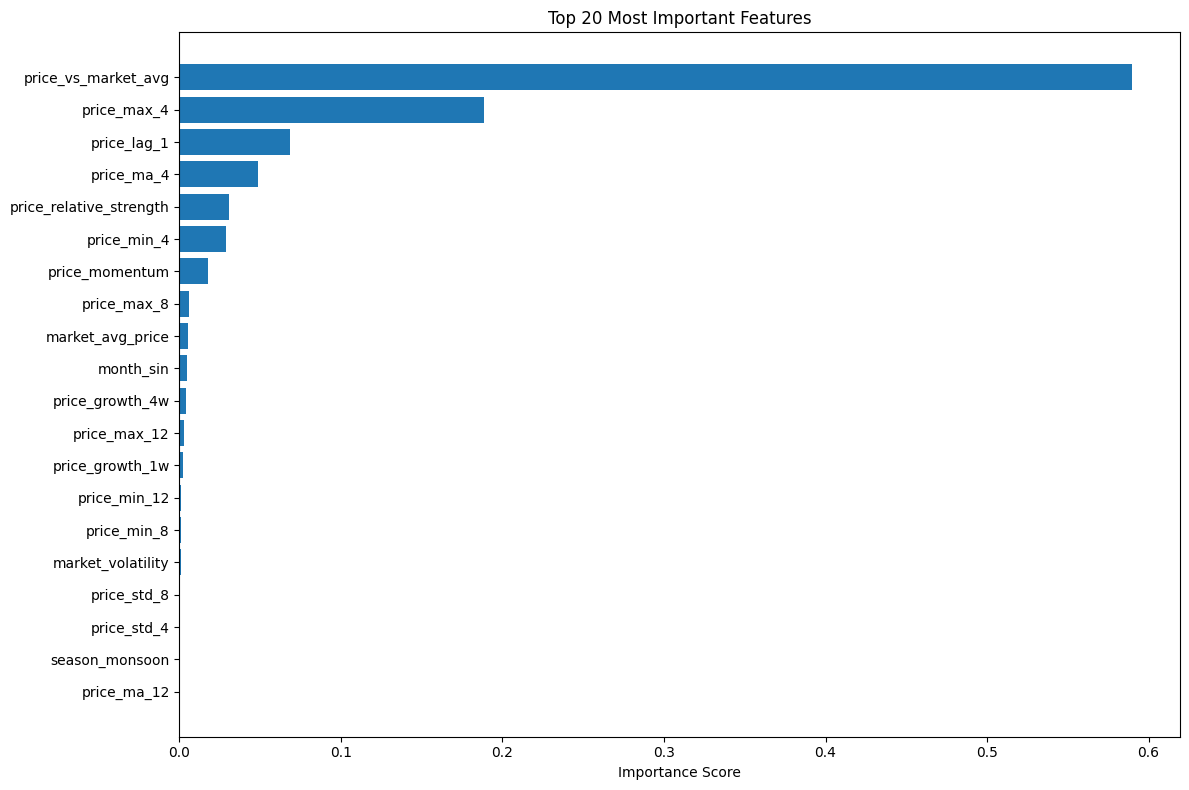


Top 10 Most Important Features:
                feature  importance
    price_vs_market_avg    0.589991
            price_max_4    0.188666
            price_lag_1    0.068144
             price_ma_4    0.048436
price_relative_strength    0.030464
            price_min_4    0.028538
         price_momentum    0.017567
            price_max_8    0.005657
       market_avg_price    0.005419
              month_sin    0.004573


In [57]:
feature_names = FEATURE_COLUMNS  
feature_importances = final_model.feature_importances_
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)
plt.figure(figsize=(12, 8))
plt.barh(fi_df.head(20)['feature'], fi_df.head(20)['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()
print("\nTop 10 Most Important Features:")
print(fi_df.head(10).to_string(index=False))

In [60]:
os.makedirs('models', exist_ok=True)


In [61]:
model_filename = f"xgboost_tomato_model_{datetime.now().strftime('%Y%m%d')}.pkl"
joblib.dump(final_model, f"models/{model_filename}")

['models/xgboost_tomato_model_20251128.pkl']

In [65]:
joblib.dump(FEATURE_COLUMNS, "models/feature_columns.pkl")


['models/feature_columns.pkl']

In [66]:
metadata = {
    'model_name': 'XGBoost Tomato Price Predictor',
    'training_date': datetime.now().isoformat(),
    'test_mae': test_mae,
    'test_mape': test_mape,
    'test_accuracy': 100 - test_mape,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'num_features': len(FEATURE_COLUMNS)
}

In [67]:
with open("models/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

now Model Training - Prophet

In [90]:
def prepare_prophet_data(df, market_name):
    """
    Prepare data for a specific market for Prophet.
    Prophet requires columns: 'ds' (date) and 'y' (value)
    """
    market_df = df[df['market_name'] == market_name].copy()
    market_df = market_df[['week_start_date', 'price_per_quintal']]
    market_df.columns = ['ds', 'y']
    market_df = market_df.sort_values('ds').reset_index(drop=True)
    return market_df
varanasi_df = prepare_prophet_data(df, 'Varanasi APMC')
print(f"Prepared {len(varanasi_df)} records for Prophet")

Prepared 69 records for Prophet


In [91]:
model = Prophet(
    yearly_seasonality=True,    
    weekly_seasonality=False,   
    daily_seasonality=False,    
    seasonality_mode='additive',  
    growth='linear',            
    n_changepoints=25,          
    changepoint_prior_scale=0.05,  
    seasonality_prior_scale=10.0,   
    holidays=None,              
    interval_width=0.80,        
    mcmc_samples=0              
)
print("Prophet model initialized")


Prophet model initialized


In [92]:
train_prophet = varanasi_df[varanasi_df['ds'] < '2025-09-01']
test_prophet = varanasi_df[varanasi_df['ds'] >= '2025-09-01']
print("Training Prophet model...")
model.fit(train_prophet)
future = model.make_future_dataframe(periods=12, freq='W')  
forecast = model.predict(future)
predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(f"Generated {len(predictions)} predictions")

07:34:49 - cmdstanpy - INFO - Chain [1] start processing


07:34:49 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...
Generated 71 predictions


In [93]:
test_predictions = predictions[predictions['ds'].isin(test_prophet['ds'])]
test_results = test_prophet.merge(test_predictions, on='ds')
prophet_mae = mean_absolute_error(test_results['y'], test_results['yhat'])
prophet_mape = np.mean(np.abs((test_results['y'] - test_results['yhat']) / test_results['y'])) * 100
prophet_rmse = np.sqrt(mean_squared_error(test_results['y'], test_results['yhat']))
prophet_accuracy = 100 - prophet_mape
print(f"\nProphet Model Results:")
print(f"MAE: {prophet_mae:.2f}")
print(f"MAPE: {prophet_mape:.2f}%")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"Accuracy: {prophet_accuracy:.2f}%")



Prophet Model Results:
MAE: 308.01
MAPE: 51.85%
RMSE: 308.01
Accuracy: 48.15%


In [94]:
fig = model.plot(forecast)
plt.title('Prophet Price Forecast - Varanasi APMC')
plt.xlabel('Date')
plt.ylabel('Price (₹/quintal)')
plt.savefig('prophet_forecast.png')
plt.close()

In [95]:
fig = model.plot_components(forecast)
plt.savefig('prophet_components.png')
plt.close()
print("Visualizations saved")

Visualizations saved


In [96]:
import pickle


In [97]:
model_path = f'models/prophet_varanasi_{datetime.now().strftime("%Y%m%d")}.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Prophet model saved: {model_path}")


Prophet model saved: models/prophet_varanasi_20251128.pkl


In [99]:
def create_sequences(data, seq_length=12, horizon=1):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length + horizon - 1])
    return np.array(X), np.array(y)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(varanasi_df['y'].values.reshape(-1, 1))
SEQ_LENGTH = 12
HORIZON = 1
X, y = create_sequences(scaled_prices, seq_length=SEQ_LENGTH, horizon=HORIZON)
split_idx = int(len(X) * 0.9)
X_train_lstm = X[:split_idx]
y_train_lstm = y[:split_idx]
X_test_lstm = X[split_idx:]
y_test_lstm = y[split_idx:]
print("X_train shape:", X_train_lstm.shape)
print("y_train shape:", y_train_lstm.shape)


X_train shape: (51, 12, 1)
y_train shape: (51, 1)


In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1)
])
model_lstm.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)
model_lstm.summary()


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,593 (463.25 KB)

 Trainable params: 118,593 (463.25 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    'models/lstm_best_model.h5',
    monitor='val_loss',
    save_best_only=True
)
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)
print("LSTM training completed.")


Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1925 - mae: 0.3024

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.2010 - mae: 0.3094 - val_loss: 8.0325e-06 - val_mae: 0.0028
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1660 - mae: 0.2717 - val_loss: 5.6223e-04 - val_mae: 0.0237
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1226 - mae: 0.2423 - val_loss: 0.0029 - val_mae: 0.0541
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0799 - mae: 0.2112 - val_loss: 0.0098 - val_mae: 0.0989
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0580 - mae: 0.2072 - val_loss: 0.0222 - val_mae: 0.1490
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0884 - mae: 0.2424 - val_loss: 0.0212 - val_mae: 0.1455
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0802 - mae: 0.2223 - val_loss: 0.0123 - val_mae: 0.1109
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0600 - mae: 0.1990 - val_loss: 0.0068 - val_mae: 0.0827
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0548 - mae: 0.1

In [ ]:
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_test_actual = scaler.inverse_transform(y_test_lstm)
y_pred_actual = scaler.inverse_transform(y_pred_lstm)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
lstm_mae = mean_absolute_error(y_test_actual, y_pred_actual)
lstm_mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print("\nLSTM Model Results:")
print(f"MAE: {lstm_mae:.2f}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"RMSE: {lstm_rmse:.2f}")
print(f"Accuracy: {100 - lstm_mape:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

LSTM Model Results:
MAE: 12.04
MAPE: 2.03%
RMSE: 12.04
Accuracy: 97.97%


In [103]:
def calculate_all_metrics(y_true, y_pred):
    """
    Calculate full evaluation metrics for model comparison.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    direction_accuracy = np.mean((y_true_diff * y_pred_diff) > 0) * 100
    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R²': r2,
        'Accuracy': 100 - mape,
        'Direction Accuracy': direction_accuracy
    }
xgb_metrics = calculate_all_metrics(y_test, y_pred_test)
prophet_metrics = calculate_all_metrics(test_results['y'], test_results['yhat'])
lstm_metrics = calculate_all_metrics(y_test_actual, y_pred_actual)
comparison_df = pd.DataFrame({
    'XGBoost': xgb_metrics,
    'Prophet': prophet_metrics,
    'LSTM': lstm_metrics
})
print("\nModel Comparison:")
print(comparison_df.to_string())


Model Comparison:
                      XGBoost     Prophet          LSTM
MAE                 14.551962  308.007700  1.204432e+01
MAPE                 0.704484   51.852275  2.027629e+00
RMSE                19.528888  308.007700  1.204432e+01
R²                   0.998466         NaN -1.122391e+28
Accuracy            99.295516   48.147725  9.797237e+01
Direction Accuracy  84.653712         NaN  0.000000e+00


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/homebrew/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [104]:
def evaluate_by_horizon(model, X, y, horizons=[7, 14, 21, 30, 45, 60]):
    """
    Evaluate accuracy for different future horizons (in days).
    """
    results = []
    for days in horizons:
        weeks = days // 7
        y_shifted = y.shift(-weeks).dropna()
        X_shifted = X.iloc[:len(y_shifted)]
        preds = model.predict(X_shifted)
        mape = np.mean(np.abs((y_shifted - preds) / y_shifted)) * 100
        accuracy = 100 - mape
        results.append({
            'horizon_days': days,
            'accuracy': accuracy
        })
    return pd.DataFrame(results)
horizon_results = evaluate_by_horizon(final_model, X_test, y_test)
print("\nAccuracy by Prediction Horizon:")
print(horizon_results.to_string(index=False))



Accuracy by Prediction Horizon:
 horizon_days  accuracy
            7 89.134734
           14 83.368488
           21 79.890197
           30 77.390069
           45 74.561006
           60 74.297245


In [105]:
def evaluate_by_market(df, model, top_n=10):
    """
    Evaluate model for every market separately.
    """
    markets = df['market_name'].unique()
    results = []
    for market in markets:
        market_df = df[df['market_name'] == market]
        if len(market_df) < 50:
            continue   
        market_train = market_df[market_df['week_start_date'] < '2025-09-01']
        market_test  = market_df[market_df['week_start_date'] >= '2025-09-01']
        if len(market_test) == 0:
            continue
        X_market_test = market_test[FEATURE_COLUMNS].fillna(0)
        y_market_test = market_test[TARGET_COLUMN]
        preds = model.predict(X_market_test)
        mape = np.mean(np.abs((y_market_test - preds) / y_market_test)) * 100
        accuracy = 100 - mape
        results.append({
            'market': market,
            'accuracy': accuracy,
            'test_samples': len(market_test)
        })
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    print(f"\nTop {top_n} Best Performing Markets:")
    print(results_df.head(top_n).to_string(index=False))
    print(f"\nBottom {top_n} Worst Performing Markets:")
    print(results_df.tail(top_n).to_string(index=False))
    return results_df
market_performance = evaluate_by_market(df, final_model)



Top 10 Best Performing Markets:
         market  accuracy  test_samples
   Maudaha APMC 99.957998             5
Pukharayan APMC 99.774127            10
   Auraiya APMC 99.761732            10
   Gazipur APMC 99.727349            10
  Shahganj APMC 99.725960            10
  Faizabad APMC 99.718160            10
     Dudhi APMC 99.710239            10
     Banda APMC 99.694717            10
   Rudauli APMC 99.678178            10
 Shahaswan APMC 99.660004            10

Bottom 10 Worst Performing Markets:
            market  accuracy  test_samples
     Bharwari APMC 98.694420            10
   Khairagarh APMC 98.659652            10
     Dhanaura APMC 98.599199            10
Varanasi(F&V) APMC 98.511286            10
     Kopaganj APMC 98.369489            10
   Panchpedwa APMC 98.367574            10
Tanda(Rampur) APMC 98.128537             4
 Tamkuhi road APMC 97.885325            10
     Khatauli APMC 97.873589             9
    Sirsaganj APMC 97.768524            10
